In [1]:
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from pathlib import Path

import networkx as nx
import geonetworkx as gnx

from dask.distributed import Client

/tmp/ipykernel_26711/1060395582.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# client = Client(n_workers=4)
# client

In [3]:
PLOTTING_PROJ = ccrs.PlateCarree()
DIST_PROJ = "+proj=eqdc +lon_0=-103.7988281 +lat_1=35.7127609 +lat_2=43.8942567 +lat_0=39.8035088 +datum=WGS84 +units=m +no_defs"

def geoax(figsize=(10, 5), **kwargs):
    f, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": PLOTTING_PROJ}, **kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    
    return f, ax

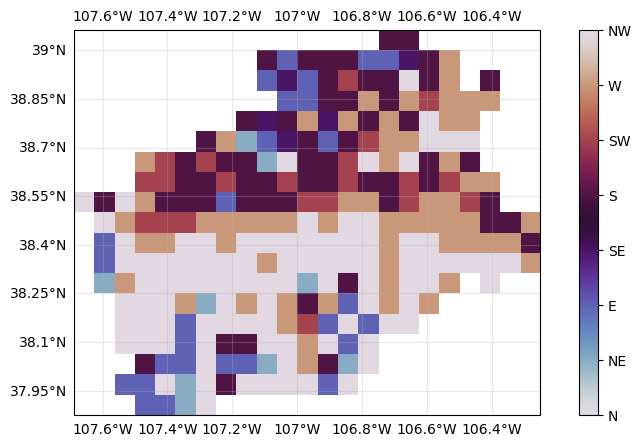

In [4]:
# read in the flow direction file
# fdr = rxr.open_rasterio("../../data/colorado/basins/gunnison/ro/pars/fl.tif", chunks=True, masked=True).persist() # dask
fdr = rxr.open_rasterio("../../data/colorado/basins/gunnison/ro/pars/fl.tif", masked=True)  # nodask
band = fdr.sel(band=1)

band_vicfmt = band  # it is already in vic-format, no need to reclassify

f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(band, fdr.rio.transform()), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [5]:
reservoirs_fn = "../../data/gunnison_reservoirs/gunnison_reservoirs_fdr_corrected_usgs_gages.csv"
reservoirs = gpd.read_file(reservoirs_fn)
reservoirs['geometry'] = gpd.points_from_xy(reservoirs['lon'], reservoirs['lat'])
reservoirs.set_crs('epsg:4326', inplace=True)

reservoirs.head()

,run,name,lon,lat,geometry
0,1,Taylor_Park,-106.604289,38.820602,POINT (-106.60429 38.82060)
1,1,Blue_Mesa,-107.333611,38.45367,POINT (-107.33361 38.45367)
2,1,Morrow_Point,-107.4877495,38.41074177,POINT (-107.48775 38.41074)
3,1,Silver_Jack,-107.540387,38.230238,POINT (-107.54039 38.23024)
4,1,EAS00,-106.8708736,38.7841599,POINT (-106.87087 38.78416)


In [6]:
reservoirs.iloc[0]

run                                     1
name                          Taylor_Park
lon                           -106.604289
lat                             38.820602
geometry    POINT (-106.604289 38.820602)
Name: 0, dtype: object

In [7]:
# # create a raster where the pixel values specify the index of reservoirs
# sampled_xy = [xy for xy in zip(reservoirs['lon'], reservoirs['lat'])]

reservoir_location_raster = xr.full_like(band_vicfmt, np.nan)
for resid, row in reservoirs.iterrows():
    reslat = float(row.lat)
    reslon = float(row.lon)

    rast_lat = reservoir_location_raster.indexes['y'].get_indexer([reslat], method="nearest")[0]
    rast_lon = reservoir_location_raster.indexes['x'].get_indexer([reslon], method="nearest")[0]

    reservoir_location_raster[rast_lat, rast_lon] = resid

In [8]:
# type(reservoirs['geometry'])

In [15]:
# convert all points to nodes. Use index value to identify
G = nx.Graph()
G.add_nodes_from(reservoirs.index)

operations = {
    1: [-1, 0],  # N
    2: [-1, 1],  # NE
    3: [0, 1],   # E
    4: [1, 1],   # SE
    5: [1, 0],   # S
    6: [1, -1],  # SW
    7: [0, -1],  # W
    8: [-1, -1], # NW
}

for node in G.nodes:
    resdata = reservoirs[reservoirs.index==node]
    
    x = float(resdata['lon'].values[0])
    y = float(resdata['lat'].values[0])

    idxx = band_vicfmt.indexes['x'].get_indexer([x], method="nearest")[0]
    idxy = band_vicfmt.indexes['y'].get_indexer([y], method="nearest")[0]
    
    # travel downstream until another node, np.nan or out-of-bounds is found, or if travelling in a loop

    visited = [(idxx, idxy)]
    current_pix = band_vicfmt.isel(x=idxx, y=idxy)

    attrs_n = {
        node: {
            'x': reservoirs['geometry'][node].x,
            'y': reservoirs['geometry'][node].y,
        }
    }
    nx.set_node_attributes(G, attrs_n)

    END = False
    while not END:
        op = operations[int(current_pix)]
        new_idxy, new_idxx = np.array((idxy, idxx)) + np.array(op)
        idxy, idxx = new_idxy, new_idxx
        
        if (new_idxx, new_idxy) in visited:
            # In a loop, exit
            END=True
            break
        else:
            visited.append((new_idxx, new_idxy))

        current_pix = band_vicfmt.isel(x=new_idxx, y=new_idxy)
        if np.isnan(current_pix):
            # NaN value found, exit loop
            END=True
            break

        try:
            any_reservoir = reservoir_location_raster.isel(x=new_idxx, y=new_idxy)
            if not np.isnan(any_reservoir):
                # another reservoir found
                G.add_edge(node, int(any_reservoir))
                attrs_e = {
                    (node, int(any_reservoir)): {
                        'length': reservoirs.to_crs(DIST_PROJ)['geometry'][node].distance(reservoirs.to_crs(DIST_PROJ)['geometry'][int(any_reservoir)])
                    }
                }
                nx.set_edge_attributes(G, attrs_e)
                END = True
                break
        except IndexError:
            print(f"Reached end")
            END=True

In [16]:
G

In [26]:
save_dir = Path("../../data/gunnison_rivreg/")

G_gdf = gpd.GeoDataFrame(gnx.graph_edges_to_gdf(G))
G_gdf_pts = gpd.GeoDataFrame(gnx.graph_nodes_to_gdf(G))  # returns a pd.DF instead of gpd.GDF, although it has a geometry column

In [35]:
# add elevation data to nodes
elevation_fn = Path("../../global_data/global_elevation_data/World_e-Atlas-UCSD_SRTM30-plus_v8.tif")
elev = rxr.open_rasterio(elevation_fn, chunks='auto')

G_gdf_pts['elevation'] = G_gdf_pts[['x', 'y']].apply(lambda row: float(elev.sel(x=row.x, y=row.y, method='nearest')), axis=1)
G_gdf_pts.head()

,x,y,id,geometry,elevation
0,-106.604289,38.820602,0,POINT (-106.60429 38.82060),2879.0
1,-107.333611,38.453670,1,POINT (-107.33361 38.45367),2322.0
2,-107.487750,38.410742,2,POINT (-107.48775 38.41074),2440.0
3,-107.540387,38.230238,3,POINT (-107.54039 38.23024),2752.0
4,-106.870874,38.784160,4,POINT (-106.87087 38.78416),2612.0


In [45]:
def slope_calculator(u, v, length, pts_gdf):
    return np.abs(pts_gdf.loc[u]['elevation'] - pts_gdf.loc[v]['elevation'])/length

# calculate slope
G_gdf['slope'] = G_gdf.apply(lambda row: slope_calculator(row.u, row.v, row.length, G_gdf_pts), axis=1)
G_gdf.head()

,u,v,length,geometry,slope
0,0,5,27344.421013,"LINESTRING (-106.60429 38.82060, -106.84810 38...",0.014701
1,1,2,14249.021726,"LINESTRING (-107.33361 38.45367, -107.48775 38...",0.008281
2,1,12,19409.753105,"LINESTRING (-107.33361 38.45367, -107.23006 38...",0.004122
3,1,16,30272.718739,"LINESTRING (-107.33361 38.45367, -106.99545 38...",0.000231
4,2,14,7120.864293,"LINESTRING (-107.48775 38.41074, -107.55522 38...",0.040023


In [46]:
# save the files
G_gdf.to_file(save_dir / "gunnison_rivreg.shp")
G_gdf_pts.to_file(save_dir / "gunnison_rivreg_pts.shp")